# Simulation Analysis Graphics for Paper - HPI Building

by: Clayton Miller

Apr 13, 2016

In [19]:
%matplotlib inline

import esoreader
reload(esoreader)
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
from __future__ import division

In [20]:
sns.set_style("whitegrid")

# Get Co-Sim Data

In [21]:

# change this to point to where you checked out the GitHub project
PROJECT_PATH = r"/Users/Clayton/Dropbox/UMEM/results/"

# this is the output of the workflow
ESO_PATH = os.path.join(PROJECT_PATH, '36-cosim-HPI', '36-cosim-HPI.eso')

# yeah... we need an index for timeseries...
HOURS_IN_YEAR = pd.date_range('2013-01-01', '2013-12-31 T23:00', freq='H')

In [22]:
hpi = esoreader.read_from_path(ESO_PATH)

In [23]:
heating = hpi.to_frame('total heating energy', index=HOURS_IN_YEAR, use_key_for_columns=False)#.sum(axis=1)
cooling = hpi.to_frame('total cooling energy', index=HOURS_IN_YEAR, use_key_for_columns=False)#.sum(axis=1)
df = pd.DataFrame({'Total Heating Energy': heating['Zone Ideal Loads Zone Total Heating Energy'], 
                   'Total Cooling Energy': cooling['Zone Ideal Loads Zone Total Cooling Energy']})
df_cosim = df*0.000000277777778

In [24]:
#hpi.dd.find_variable("Heating Energy")

# Get E+ Solo Data

In [25]:
# this is the output of the workflow
ESO_PATH = os.path.join(PROJECT_PATH, '35-energyplus-HPI', '35-energyplus-HPI.eso')

In [26]:
hpi = esoreader.read_from_path(ESO_PATH)
heating = hpi.to_frame('total heating energy', index=HOURS_IN_YEAR, use_key_for_columns=False)#.sum(axis=1)
cooling = hpi.to_frame('total cooling energy', index=HOURS_IN_YEAR, use_key_for_columns=False)#.sum(axis=1)
df = pd.DataFrame({'Total Heating Energy': heating['Zone Ideal Loads Zone Total Heating Energy'], 
                   'Total Cooling Energy': cooling['Zone Ideal Loads Zone Total Cooling Energy']})
df_eplus = df*0.000000277777778

# Get Measured Data

In [27]:
workingdir = "/Users/Clayton/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"
df_meas = pd.read_csv(workingdir+"aggset2_QW/HPI_QW.csv", index_col="Date Time", parse_dates=True, na_values=0)
point = "HPIMKA01QW_A [kWh]"
df_meas_cooling = pd.DataFrame(df_meas[point].truncate(before='2013',after='2014'))
df_meas_cooling = df_meas_cooling[(df_meas_cooling<50)]

In [28]:
point = "HPIMHE01QW_A [kWh]"
df_meas_heating = pd.DataFrame(df_meas[point].truncate(before='2013',after='2014'))
df_meas_heating = df_meas_heating[(df_meas_heating<1000)]

In [29]:
df_meas = pd.DataFrame({'Total Heating Energy': df_meas_heating["HPIMHE01QW_A [kWh]"], 
                   'Total Cooling Energy': df_meas_cooling["HPIMKA01QW_A [kWh]"]})

# Combine

In [30]:
df_allcooling = pd.DataFrame({"Co-Simulation Cooling Energy":df_cosim['Total Cooling Energy'], 
                              "EnergyPlus Solo Cooling Energy":df_eplus['Total Cooling Energy'],"Measured Cooling":df_meas['Total Cooling Energy'],
                              }) #"Measured":df_meas['Total Cooling Energy']
df_allcooling = df_allcooling.truncate(after='2013-12-31 23:00')

In [31]:
df_allheating = pd.DataFrame({"Co-Simulation Heating Energy":df_cosim['Total Heating Energy'],
                              "EnergyPlus Solo Heating Energy":df_eplus['Total Heating Energy'],"Measured Heating":df_meas['Total Heating Energy']
                             }) # "Measured":df_meas['Total Heating Energy']"Co-Simulation Heating Energy":df_cosim['Total Heating Energy'],
df_allheating = df_allheating.truncate(after='2013-12-31 23:00')

In [32]:
df_allheating_winter = pd.concat([df_allheating.truncate(after="2013-04-28 23:00"), df_allheating.truncate(before="2013-10-07")])
df_allheating_winter = df_allheating_winter.dropna()

In [33]:
df_allcooling_summer = df_allcooling.truncate(before="2013-04-29",after="2013-10-06 23:00").dropna()

In [34]:
combinedheating_cooling = pd.merge(df_allheating_winter,df_allcooling_summer, right_index=True, left_index=True, how='outer')

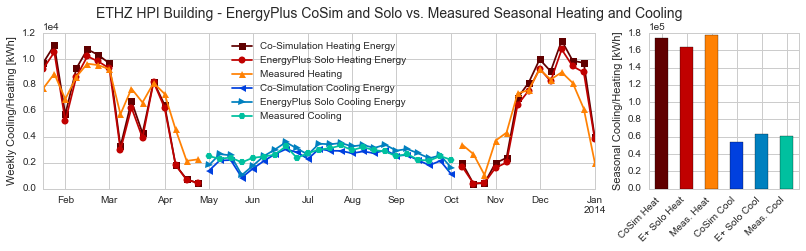

In [35]:
palette1 = sns.color_palette("gist_heat", 3)
palette2 = sns.color_palette("winter", 3)
sns.set_palette(palette1+palette2)


fig1 = plt.figure(figsize=[15,3])
fig1.suptitle("ETHZ HPI Building - EnergyPlus CoSim and Solo vs. Measured Seasonal Heating and Cooling", fontsize=14, y=1.02)

gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))

ax1 = fig1.add_subplot(gs[:,0:73])
styles1 = ['s-','o-','^-','<-','->','-H']
combinedheating_cooling.resample("W",how='sum').plot(style=styles1, ax=ax1)
ax1.set_ylabel("Weekly Cooling/Heating [kWh]")
gca().yaxis.set_major_formatter(xfmt)

df_bar_combined = combinedheating_cooling
df_bar_combined.columns = ["CoSim Heat","E+ Solo Heat","Meas. Heat","CoSim Cool","E+ Solo Cool","Meas. Cool"]
ax3 = fig1.add_subplot(gs[:,80:100])
df_bar_combined.resample('A',how='sum').T.plot(kind='bar',color=palette1+palette2, legend=False, ax=ax3)
ax3.set_ylabel("Seasonal Cooling/Heating [kWh]")
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
for tick in ax3.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
gca().yaxis.set_major_formatter(xfmt)

plt.subplots_adjust(bottom=0.5)

plt.savefig("/Users/Clayton/umem-jbps-paper/latex/figures/"+"HPI_MeasvsSim.pdf",bbox_inches='tight')
plt.show()

# Daily Profiles

In [36]:
def pivot_day(df, cols, startdate, enddate):
    df_forpiv = df.truncate(before=startdate, after=enddate).resample('2H', how='mean')
    #df_cooling_forpiv.columns = ["1","2","3","4"]

    df_forpiv['Date'] = df_forpiv.index.map(lambda t: t.date())
    df_forpiv['Time'] = df_forpiv.index.map(lambda t: t.time())

    df_pivot_1 = pd.pivot_table(df_forpiv, values=cols[0], index='Date', columns='Time')
    df_pivot_2 = pd.pivot_table(df_forpiv, values=cols[1], index='Date', columns='Time')
#     df_pivot_3 = pd.pivot_table(df_forpiv, values=cols[2], index='Date', columns='Time')
#     df_pivot_4 = pd.pivot_table(df_forpiv, values=cols[3], index='Date', columns='Time')

    df_pivot_sum = pd.DataFrame()
    df_pivot_sum[cols[0]] = df_pivot_1.mean()#.plot(figsize=(20,8))
    df_pivot_sum[cols[1]] = df_pivot_2.mean()#.plot()
#     df_pivot_sum[cols[2]] = df_pivot_3.mean()#.plot()
#     df_pivot_sum[cols[3]] = df_pivot_4.mean()#.plot()
    
    return df_pivot_sum

In [43]:
def plot_cosim_vs_solo(df, df_pivot, colorpalette, ylabel1, ylabel2, ylabel3, filename, title, colnames):
    current_palette = sns.color_palette(colorpalette, 2)
    sns.set_palette(current_palette)

    fig1 = plt.figure(figsize=[15,3])
    fig1.suptitle(title, fontsize=14, y=1.03)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    xfmt = ScalarFormatter()
    xfmt.set_powerlimits((-3,3))
    
    ax1 = fig1.add_subplot(gs[:,1:35])
    styles1 = ['s-','^-','<-']
    df.columns = colnames
    df_pivot.columns = colnames
    df_pivot.plot(style=styles1, ax=ax1, xticks=arange(0, 86400, 21600))

    ax1.set_ylabel(ylabel1)
    ax1.set_xlabel("Time of Day")
    gca().yaxis.set_major_formatter(xfmt)
    
    ax2 = fig1.add_subplot(gs[:,41:75])
    styles1 = ['s-','^-','<-']
    
    df.resample('M',how='sum').plot(style=styles1, ax=ax2)#.legend(loc='center left', bbox_to_anchor=(0, -0.5),), title="Monthly Total"
    ax2.set_ylabel(ylabel2)
    ax2.set_xlabel("Months of Year")

    gca().yaxis.set_major_formatter(xfmt)

    # df_netradiation.resample('M',how='sum').plot(style=styles1, ax=ax2, title="Monthly Total All Surfaces")#.legend(loc='center left', bbox_to_anchor=(0, -0.5),)
    # ax2.set_ylabel("Monthly Net Thermal Radiation [J]")
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'));

    df_bar = df.resample('A',how='sum')
    #df_bar.columns = ["CoSim","Solo"] #,"3","4"
    ax3 = fig1.add_subplot(gs[:,81:100])
    df_bar.T.plot(kind='bar',color=current_palette, legend=False, ax=ax3) #, title="Annual Total"
    ax3.set_ylabel(ylabel3)
    gca().yaxis.set_major_formatter(xfmt)
    
    diff = float((df_bar.ix[:,1] - df_bar.ix[:,0])/df_bar.ix[:,0])
    if diff >= 0:
        annotation = '+{:.1%}'.format(diff)
    else:
        annotation = '{:.1%}'.format(diff)
        
    delta = int(df_bar.ix[:,1] - df_bar.ix[:,0])
    if delta >= 0:
        annotation_delta = '+{:,} kWh'.format(delta)
    else:
        annotation_delta = '{:,} kWh'.format(delta)


    ax3.annotate(annotation, xy=(0, 10000), xytext=(0.8, df_bar["CoSim"][0]+(df_bar.max().max() / 30)))
    ax3.annotate(annotation_delta, xy=(0, 10000), xytext=(0.55, df_bar["CoSim"][0]+(df_bar.max().max() / 8)))
    plt.ylim([0,df_bar.max().max()+df_bar.max().max()*.2])
    # ax2.set_xticklabels(colnames, rotation=80)
    plt.subplots_adjust(bottom=0.5)
    # plt.tight_layout()
    plt.savefig("/Users/Clayton/umem-jbps-paper/latex/figures/"+filename,bbox_inches='tight')
    plt.show()
    
    

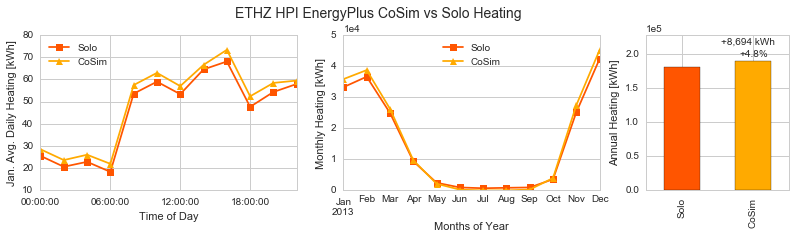

In [44]:
heating = df_allheating[['EnergyPlus Solo Heating Energy','Co-Simulation Heating Energy']]
heating_pivot = pivot_day(heating, list(heating.columns), '2013-01-01','2013-01-31')
df_bar = plot_cosim_vs_solo(heating, heating_pivot, "autumn", "Jan. Avg. Daily Heating [kWh]", "Monthly Heating [kWh]", "Annual Heating [kWh]", "HPI_EnergyPlus_Heating.pdf","ETHZ HPI EnergyPlus CoSim vs Solo Heating",["Solo","CoSim"])

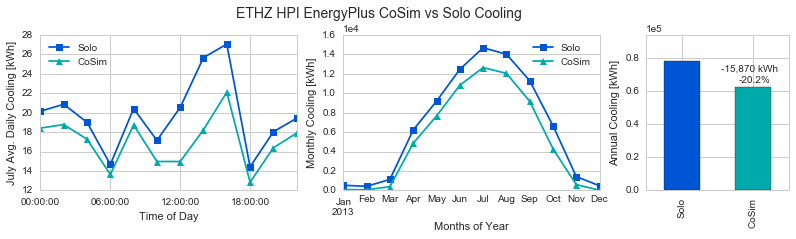

In [45]:
cooling = df_allcooling[['EnergyPlus Solo Cooling Energy','Co-Simulation Cooling Energy']]
cooling_pivot = pivot_day(cooling, list(cooling.columns), '2013-07-01','2013-07-31')
plot_cosim_vs_solo(cooling, cooling_pivot, "winter", "July Avg. Daily Cooling [kWh]", "Monthly Cooling [kWh]", "Annual Cooling [kWh]", "HPI_EnergyPlus_Cooling.pdf","ETHZ HPI EnergyPlus CoSim vs Solo Cooling",["Solo","CoSim"])